In [ ]:
# hide
# all_tutorial
! [ -e /content ] && pip install -Uqq mrl-pypi  # upgrade mrl on colab

# Adeno-Associated Virus Capsid Design

>Using MRL to design AAV capsids

## Adeno-Associated Virus Capsid Design

This tutorial runs an end to end workflow for designing AAV capsids

Adeno-Associated Viruses (AAV) are small viruses that generally do not cause disease. The non-pathogenic nature of these viruses makes them an attractive target for gene therapy delivey vectors. One drawback to using AAV capsids for gene deivery is they can be neutralized by natural immunity. This sets up a protein engineering problem. We want to develop new variants of the virus that caan evade the human immune system.

We could approach this with a scanning mutation approach, but this would result in a high number of invalid sequences. Instead, we will build a score function based off laboratory data and use a generative model to exploit this score function. We hope this approach will give more realistic variants.

## Performance Notes

The workflow in this notebook is more CPU-constrained than GPU-constrained due to the need to evaluate samples on CPU. If you have a multi-core machine, it is recommended that you uncomment and run the `set_global_pool` cells in the notebook. This will trigger the use of multiprocessing, which will result in 2-4x speedups.

This notebook may run slow on Collab due to CPU limitations.

If running on Collab, remember to change the runtime to GPU

In [ ]:
import sys
sys.path.append('..')

from mrl.imports import *
from mrl.core import *
from mrl.chem import *
from mrl.templates.all import *

from mrl.torch_imports import *
from mrl.torch_core import *
from mrl.layers import *
from mrl.dataloaders import *
from mrl.g_models.all import *
from mrl.vocab import *
from mrl.policy_gradient import *
from mrl.train.all import *
from mrl.model_zoo import *
from sklearn.metrics import r2_score

/home/dmai/miniconda3/envs/bio-transformers/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.
  return f(*args, **kwds)


In [ ]:
os.makedirs('untracked_files', exist_ok=True)

## Data

The dataset comes from the paper [Generative AAV capsid diversification by latent interpolation ](https://www.biorxiv.org/content/10.1101/2021.04.16.440236v1.full.pdf). The authors looked at a 28 amino acid section of the AAV2 VP3 protein shown to have immunological significance.

The authors created a mutation library based on 564 naturally occurring sequences. They then trained a VAE model on this dataset, sampled new 28-AA sequences from this model, and tested them in the lab.

We will use their laboratory data to build a score function. Then we will run a generative screen against that score function

In [ ]:
# download data
# ! wget https://raw.githubusercontent.com/churchlab/Generative_AAV_design/main/Data/vae2021_processed_data.csv

In [ ]:
df = pd.read_csv('vae2021_processed_data.csv')

In [ ]:
df.dropna(subset=['VAE_virus_S'], inplace=True)

In [ ]:
df.head()

,Unnamed: 0,category_orig,lin_fit,pred_fit,sampling,aa,wt_dist,mask,VAE_virus_S,mut,category,wt_conserved_pos,colors,beats_wt,viable
0,0,VAE-MSA,-47.652505,29.069985,most_likely,DEEEIRTTNPVATEQYGVTATNLQNSNT,6,_________________VTA____NS_T,6.660194,6.0,VAE-MSA,22.0,plum,1,1
1,1,VAE-MSA,-48.071833,28.955883,most_likely,SEEEIRTTNPVATEQYGTTATNLQSSNT,7,S________________TTA____SS_T,2.716090,7.0,VAE-MSA,21.0,plum,0,1
2,2,VAE-MSA,-47.482053,28.946108,most_likely,DEEEIRTTNPVATEQYGVTATNLQNSTT,7,_________________VTA____NSTT,6.619935,7.0,VAE-MSA,21.0,plum,1,1
3,3,VAE-MSA,-47.745287,28.280085,most_likely,DEEEIRTTNPVATEQYGVTATNLQSSNT,6,_________________VTA____SS_T,6.344426,6.0,VAE-MSA,22.0,plum,1,1
4,4,VAE-MSA,-46.253139,28.170899,most_likely,DEEEIRTTNPVATEQYGTTATNLQNSNT,6,_________________TTA____NS_T,6.148984,6.0,VAE-MSA,22.0,plum,1,1


Our metric of interest is `VAE_virus_S`. This is the log-2 ratio of the frequency of a variant in a virus pool relative to the frequency of the corresponding plasmid in the plasmid pool. Higher values indicate higher viability. The goal of the design is to produce variants predicted to beat the wildtype sequence. The dataset indicates which sequences are currently performing at this level

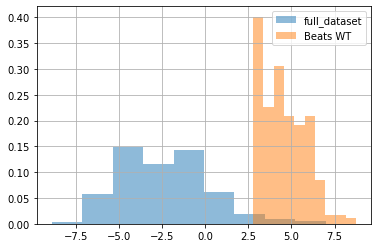

In [ ]:
df.VAE_virus_S.hist(alpha=0.5, density=True, label='full_dataset')
df[(df.viable==1) & (df.beats_wt==1)].VAE_virus_S.hist(alpha=0.5, density=True, label='Beats WT')
plt.legend();

## Score Function

Now we want to develop a score function for predicting antimicrobial activity. We will use a CNN encoder with a MLP head to predict the score described above.

Our input data will be token integers for amino acids. Note that fingerprint representations are a poor fit for peptide work because peptides contain many repeating substructures.

We will train on 90% of the data and validate on the 10% held out.

In [ ]:
train_df = df.sample(frac=0.9, random_state=42).copy()
valid_df = df[~df.index.isin(train_df.index)].copy()

In [ ]:
aa_vocab = CharacterVocab(AMINO_ACID_VOCAB)

train_ds = Text_Prediction_Dataset(train_df.aa.values, train_df.VAE_virus_S.values, aa_vocab)
test_ds = Text_Prediction_Dataset(valid_df.aa.values, valid_df.VAE_virus_S.values, aa_vocab)

This is the model we will use:

In [ ]:
class Predictive_CNN(nn.Module):
    def __init__(self,
                 d_vocab,
                 d_embedding,
                 d_latent,
                 filters,
                 kernel_sizes,
                 strides,
                 dropouts,
                 mlp_dims,
                 mlp_drops,
                 d_out,
                 outrange
                ):
        super().__init__()
        
        self.conv_encoder = Conv_Encoder(
                                        d_vocab,
                                        d_embedding,
                                        d_latent,
                                        filters,
                                        kernel_sizes,
                                        strides,
                                        dropouts,
                                    )
        
        self.mlp_head = MLP(
                            d_latent,
                            mlp_dims,
                            d_out,
                            mlp_drops,
                            outrange=outrange
                            )
        
    def forward(self, x):
        encoded = self.conv_encoder(x)
        out = self.mlp_head(encoded)
        return out

In [ ]:
d_vocab = len(aa_vocab.itos)
d_embedding = 256
d_latent = 512
filters = [256, 512, 1024]
kernel_sizes = [7, 7, 7]
strides = [2,2,2]
dropouts = [0.2, 0.2, 0.2]
mlp_dims = [512, 256, 128]
mlp_drops = [0.2, 0.2, 0.2]
d_out = 1
outrange = [-10, 10]


virus_model = Predictive_CNN(
                    d_vocab,
                    d_embedding,
                    d_latent,
                    filters,
                    kernel_sizes,
                    strides,
                    dropouts,
                    mlp_dims,
                    mlp_drops,
                    d_out,
                    outrange
                )

In [ ]:
r_agent = PredictiveAgent(virus_model, MSELoss(), train_ds, opt_kwargs={'lr':1e-3})

In [ ]:
r_agent.train_supervised(32, 20, 1e-3)

Epoch,Train Loss,Valid Loss,Time
0,3.82397,3.43804,00:06
1,3.80967,3.17915,00:06
2,2.48006,1.58518,00:06
3,1.86415,1.09765,00:06
4,1.34830,0.79360,00:06
5,1.46673,0.69241,00:06
6,1.37931,0.57727,00:06
7,2.57791,0.69516,00:06
8,1.28085,0.90489,00:06
9,1.70550,0.53054,00:06


Optional: save score function weights

In [ ]:
# r_agent.save_weights('untracked_files/virus_predictor.pt')

Optional: to load the exact weights used, run the following:

In [ ]:
# r_agent.load_state_dict(model_from_url('virus_predictor.pt'))

In [ ]:
# validate

valid_dl = test_ds.dataloader(256, num_workers=0, shuffle=False)
r_agent.model.eval();

preds = []
targs = []

with torch.no_grad():
    for i, batch in enumerate(valid_dl):
        batch = to_device(batch)
        x,y = batch
        pred = r_agent.model(x)
        preds.append(pred.detach().cpu())
        targs.append(y.detach().cpu())
        
preds = torch.cat(preds).numpy()
targs = torch.cat(targs).numpy()

preds = preds.squeeze(-1)

Our score function has an r^2 value of about 0.883 on the validation dataset

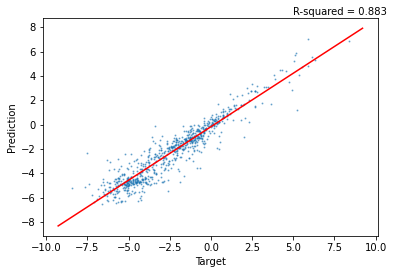

In [ ]:
fig, ax = plt.subplots()

ax.scatter(targs, preds, alpha=0.5, s=1)
plt.xlabel('Target')
plt.ylabel('Prediction')

slope, intercept = np.polyfit(targs, preds, 1)
ax.plot(np.array(ax.get_xlim()), intercept + slope*np.array(ax.get_xlim()), c='r')

plt.text(5., 9., 'R-squared = %0.3f' % r2_score(targs, preds));

We should also take a look at the prediction distribution for our known actives. The predicted values will differ somewhat from the actual values. This will give us a sense of what score we want to see from the model 

In [ ]:
df['preds'] = r_agent.predict_data(df.aa.values).detach().cpu().numpy()

In [ ]:
df.preds.max()

8.637711

In [ ]:
np.percentile(df.preds, 99)

5.337126960754395

The maximum predicted value is `8.63`. A compound scoring `5.33` or higher would be in the top 1% of all known sequences

## Chemical Space

Next we need to develop our chemical space. This is where we decide what sequences will be allowed and what sequences will be removed.

Getting the right filtering parameters makes a huge difference in sequence quality. In practice, finding the right constraints is an interative process. First run a generative screen. Then examine the highest scoring sequences and look for undesirable properties or structural features. Then update the template and iterate.

For peptides, the presence of Arginine has shown to be toxic [[ref](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5625148/)]. We will apply a template filter for the number of Arginine residues per unit length.

We will also limit the maximum residue frequency in a sample to 0.3. This prevents a common failure mode of seeing the same residue repeated multiple times (ie `MSSSSSSSRP`). This is a flaw in the simplistic score functions we are using

In [ ]:
aa_vocab = CharacterVocab(AMINO_ACID_VOCAB)

template = Template([ValidityFilter(),
                     CharacterCountFilter(['A'], min_val=0, max_val=0.1, per_length=True, mode='protein'),
                     CharacterCountFilter(aa_vocab.itos[4:], min_val=0, max_val=0.3, 
                                          per_length=True, mode='protein')], 
                    [], fail_score=-10., log=False, use_lookup=False, mode='protein')

template_cb = TemplateCallback(template, prefilter=True)

## Load Model

We load the `LSTM_LM_Small_Swissprot` model. This is a basic LSTM-based language model trained on part of the Swissprot protein database

In [ ]:
agent = LSTM_LM_Small_Swissprot(drop_scale=0.3, opt_kwargs={'lr':5e-5})

## Fine-Tune Model

The pretrained model we loaded is a very general model that can produce a high diversity of structures. However, what we actually want are structues with antimicrobial activity. To induce this, we fine-tune on high scoring sequences.

The dataset denotes two categories for high scoring sequences. The `viable` category contains ~3000 samples that were able to successfully assemble and package genetic material. The `beats_wt` category contains ~300 samples with higher expression than the wildtype variant.

The `beats_wt` dataset feels a bit small for fine-tuning, so we will first fine-tune on the `viable` dataset, then the `beats_wt` dataset

In [ ]:
agent.update_dataset_from_inputs(df[df.viable==1].aa.values)
agent.train_supervised(32, 8, 1e-5)

agent.update_dataset_from_inputs(df[df.beats_wt==1].aa.values)
agent.train_supervised(32, 6, 1e-5)

agent.base_to_model()

Epoch,Train Loss,Valid Loss,Time
0,3.09644,3.13637,00:07
1,2.88747,2.91808,00:07
2,2.69400,2.64680,00:07
3,2.27077,2.41548,00:07
4,2.37047,2.24352,00:07
5,2.29873,2.15897,00:07
6,2.30229,2.12705,00:07
7,2.26235,2.12265,00:07


Epoch,Train Loss,Valid Loss,Time
0,1.89840,1.86490,00:06
1,1.91238,1.84932,00:06
2,1.88062,1.83178,00:06
3,1.86695,1.81948,00:06
4,2.02561,1.81402,00:06
5,1.87679,1.81318,00:06


Optional: save fine-tuned weights

In [ ]:
# agent.save_weights('untracked_files/finetuned_model.pt')

In [ ]:
# agent.load_weights('untracked_files/finetuned_model.pt')

# Reinforcement Learning

Now we enter the reinforcement learning stage

### Loss

We use `PPO` as our policy gradient loss

In [ ]:
pg = PPO(0.99,
        0.5,
        lam=0.95,
        v_coef=0.5,
        cliprange=0.3,
        v_cliprange=0.3,
        ent_coef=0.01,
        kl_target=0.03,
        kl_horizon=3000,
        scale_rewards=True)

loss = PolicyLoss(pg, 'PPO', 
                   value_head=ValueHead(256), 
                   v_update_iter=2, 
                   vopt_kwargs={'lr':1e-3})

### Reward

Here we pass the reward agent we trained earlier to a callback.

In [ ]:
aa_vocab = CharacterVocab(AMINO_ACID_VOCAB)

d_vocab = len(aa_vocab.itos)
d_embedding = 256
d_latent = 512
filters = [256, 512, 1024]
kernel_sizes = [7, 7, 7]
strides = [2,2,2]
dropouts = [0.2, 0.2, 0.2]
mlp_dims = [512, 256, 128]
mlp_drops = [0.2, 0.2, 0.2]
d_out = 1
outrange = [-10, 10]


reward_model = Predictive_CNN(
                    d_vocab,
                    d_embedding,
                    d_latent,
                    filters,
                    kernel_sizes,
                    strides,
                    dropouts,
                    mlp_dims,
                    mlp_drops,
                    d_out,
                    outrange
                )

r_ds = Text_Prediction_Dataset(['M'], [0.], aa_vocab)

r_agent = PredictiveAgent(reward_model, MSELoss(), r_ds, opt_kwargs={'lr':1e-3})

r_agent.load_weights('untracked_files/virus_predictor.pt')
# r_agent.load_state_dict(model_from_url('virus_predictor.pt')) # optional - load exact weights

reward_model.eval();

freeze(reward_model)

reward_function = Reward(r_agent.predict_data, weight=1)

virus_reward = RewardCallback(reward_function, 'virus')

### Optional Reward: Stability Metric

There has been a lot of great work recently looking at large scale transformer language models for unsupervised learning of protein structures. One interesting thing that has emerged is a rough relationship between the protein sequence log probability given by a generative model and the stability of the protein sequence.

We can use the log probability values from a pretrained protein transformer model as a proxy for stability. Including this as a reward function can help keep the generated peptides realistic.

To include this as a reward term, run the code below to install the [ESM](https://github.com/facebookresearch/esm) library to access a pretrained protein transformer model.

In the interest of time, we will use the smallest ESM model with 43M parameters, rather than the large scale 630M parameter model. Note that even with the smaller model, this reward term adds significanly to the training runtime

In [ ]:
# Optional: insall ESM
# ! pip install fair-esm

In [ ]:
import esm

In [ ]:
protein_model, alphabet = esm.pretrained.esm1_t6_43M_UR50S()
batch_converter = alphabet.get_batch_converter()

In [ ]:
class PeptideStability():
    def __init__(self, model, alphabet, batch_converter):
        self.model = model
        to_device(self.model)
        self.alphabet = alphabet
        self.batch_converter = batch_converter
        
    def __call__(self, samples):
        
        data = [
            (f'protein{i}', samples[i]) for i in range(len(samples))
        ]
        
        batch_labels, batch_strs, batch_tokens = self.batch_converter(data)

        with torch.no_grad():
            results = self.model(to_device(batch_tokens))

        lps = F.log_softmax(results['logits'], -1)

        mean_lps = lps.gather(2, to_device(batch_tokens).unsqueeze(-1)).squeeze(-1).mean(-1)
        
        return mean_lps

In [ ]:
ps = PeptideStability(protein_model, alphabet, batch_converter)

In [ ]:
stability_reward = Reward(ps, weight=0.1, bs=300)
stability_cb = RewardCallback(stability_reward, name='stability')

In [ ]:
stability_reward(df.aa.values[:10])

tensor([-0.4359, -0.4157, -0.4197, -0.4416, -0.4249, -0.4359, -0.4065, -0.4426,
        -0.4420, -0.4499], device='cuda:0')

### Samplers

We create the following samplers:
- `sampler1 ModelSampler`: this samples from the main model. This sample will add 1000 compounds to the buffer each buffer build, and sample 40% of each batch on the fly from the main model.
- `sampler2 ModelSampler`: this samples from the baseline model and is not sampled live on each batch
- `sampler3 LogSampler`: this samples high scoring samples from the lig
- `sampler4 TokenSwapSampler`: this uses token swap comibichem to generate new samples from high scoring samples
- `sampler5 DatasetSampler`: this sprinkles in a small amount of high scoring samples into each buffer build.

In [ ]:
gen_bs = 1500

sampler1 = ModelSampler(agent.vocab, agent.model, 'live', 1000, 0.4, gen_bs)
sampler2 = ModelSampler(agent.vocab, agent.base_model, 'base', 1000, 0., gen_bs)
sampler3 = LogSampler('samples', 'rewards', 10, 95, 100)
sampler4 = TokenSwapSampler('samples', 'rewards', 10, 95, 100, aa_vocab, 0.1)
sampler5 = DatasetSampler(df[(df.beats_wt==1)].aa.values, 
                          'data', buffer_size=4)

samplers = [sampler1, sampler2, sampler3, sampler4, sampler5]

### Callbacks

Additional callbacks
- `SupervisedCB`: runs supervised training on the top 3% of samples every 400 batches
- `MaxCallback`: prints the max reward for each batch
- `PercentileCallback`: prints the 90th percentile score each batch
- `ResetAndRetrain`: reloads the base model and retrained on the top 10% of samples every 2000 batches
- `Timeout`: prohibits training on the same sample more than once every 20 batches

In [ ]:
supervised_cb = SupervisedCB(agent, 400, 0.5, 97, 5e-5, 64)
live_max = MaxCallback('rewards', 'live')
live_p90 = PercentileCallback('rewards', 'live', 90)
retrain_cb = ResetAndRetrain(agent, 1000, agent.weight_filepath,
               90, 5e-5, 64, 3)
tm_cb = Timeout(20)

cbs = [supervised_cb, live_p90, live_max, retrain_cb, tm_cb]

## Environment and Train

Now we can put together our Environment and run the training process

In [ ]:
env = Environment(agent, template_cb, samplers=samplers, rewards=[virus_reward, stability_cb], losses=[loss],
                 cbs=cbs)

In [ ]:
set_global_pool(min(12, os.cpu_count()))

In [ ]:
env.fit(200, 28, 5000, 100)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,live_diversity,live_valid,live_rewards,live_new,virus,stability,timeout,PPO,rewards_live_p90,rewards_live_max
0,-4.735,-4.735,1.000,1.000,183,0.000,0.915,1.000,0.787,-4.102,1.000,-4.135,-0.601,1.000,9.582,-1.755,-0.904
100,-4.704,-4.704,0.924,1.000,157,0.000,0.800,1.000,0.500,-4.776,1.000,-4.211,-0.494,0.981,0.658,-2.407,-1.048
200,-4.624,-4.624,0.962,1.000,156,0.000,0.790,1.000,0.475,-4.126,1.000,-4.133,-0.491,0.987,0.368,-1.957,-1.155
300,-4.381,-4.381,0.942,1.000,138,0.000,0.700,1.000,0.250,-3.661,1.000,-3.605,-0.776,0.986,0.325,-1.868,-1.297
400,-3.140,-3.140,0.917,1.000,168,0.000,0.860,1.000,0.650,-3.077,1.000,-2.331,-0.810,0.977,0.591,-1.818,-1.288
500,-1.950,-1.950,0.946,1.000,148,0.000,0.755,1.000,0.388,-1.776,1.000,-1.477,-0.472,0.980,0.138,-1.093,-0.479
600,-1.705,-1.705,0.907,1.000,140,0.000,0.705,1.000,0.263,-1.845,1.000,-1.203,-0.501,0.993,0.133,-0.882,-0.677
700,-1.386,-1.386,0.893,1.000,140,0.000,0.715,1.000,0.287,-1.149,1.000,-0.916,-0.470,0.979,0.055,-0.760,0.056
800,-1.266,-1.266,0.899,1.000,178,0.000,0.920,1.000,0.800,-1.312,1.000,-0.799,-0.466,0.967,0.943,-0.686,-0.380
900,-1.122,-1.122,0.963,1.000,164,0.000,0.825,1.000,0.562,-1.035,1.000,-0.657,-0.465,0.994,0.035,-0.543,-0.069


Epoch,Train Loss,Valid Loss,Time
0,2.22062,2.26341,00:10
1,2.20476,2.19417,00:10
2,2.18762,2.18146,00:10


Epoch,Train Loss,Valid Loss,Time
0,1.72720,1.70530,00:15
1,1.69025,1.67675,00:15
2,1.67385,1.66485,00:15


Epoch,Train Loss,Valid Loss,Time
0,1.47540,1.32013,00:19
1,1.30728,1.28894,00:19
2,1.37068,1.28801,00:18


Epoch,Train Loss,Valid Loss,Time
0,1.04671,1.18071,00:23
1,0.97706,1.15204,00:22
2,0.99117,1.15225,00:22


Epoch,Train Loss,Valid Loss,Time
0,0.67244,0.64999,00:25
1,0.61697,0.64895,00:25
2,0.66509,0.64937,00:25


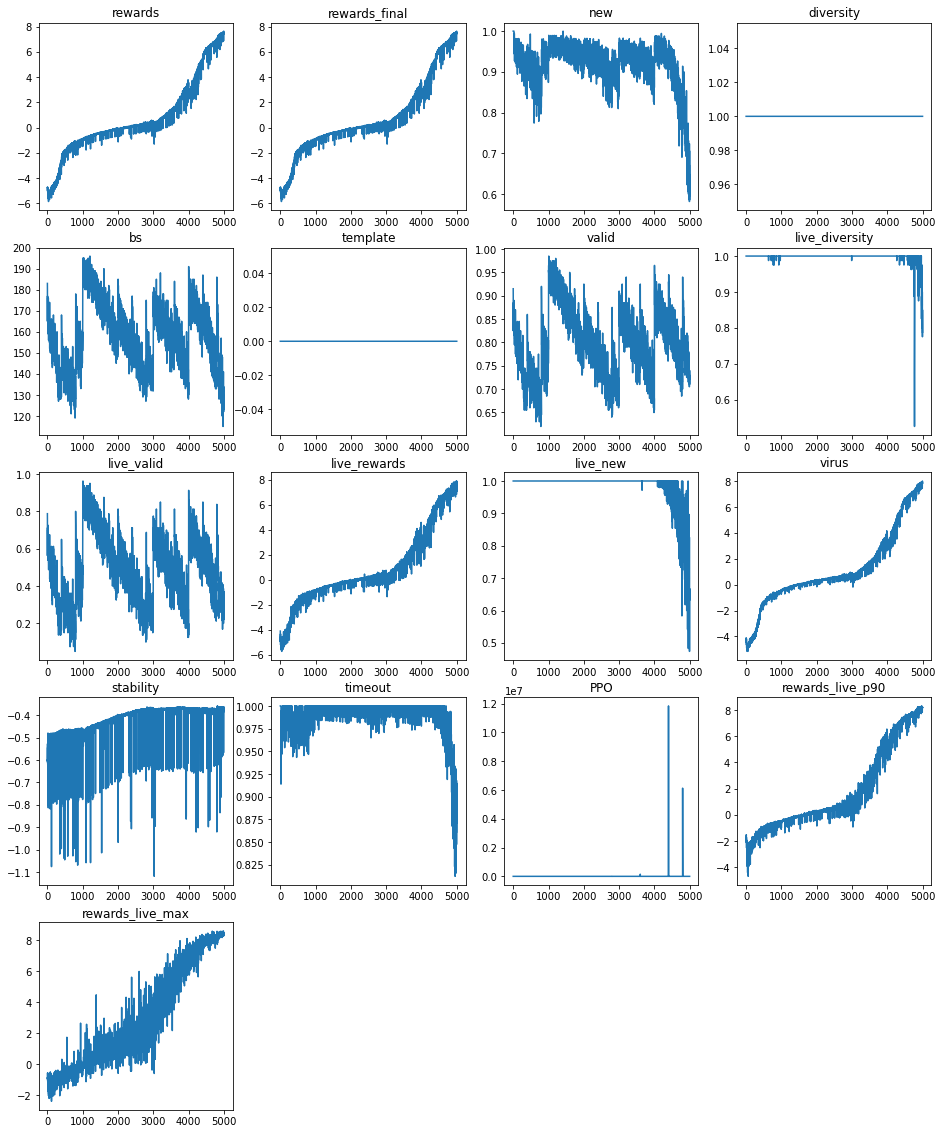

In [ ]:
env.log.plot_metrics()

## Evaluation

Based on our score function, we determined a sequence with a predicted score of 5.33 or higher would be in the top 1% of sequences relative to the training data. A sequence with a predicted score of 8.63 or higher would beat out all sequences in the dataset

We found 97901 sequences with a predicted score of 5.33 or higher and 504 sequences with a predicted score of 8.63 or higher

In [ ]:
env.log.df[(env.log.df.virus>5.33) & ~(env.log.df.sources=='data_buffer')].shape

(97901, 8)

In [ ]:
env.log.df[(env.log.df.virus>8.63) & ~(env.log.df.sources=='data_buffer')].shape

(504, 8)

We can generate logo stack plots to visualize what residues are favored

In [ ]:
from collections import Counter, defaultdict

In [ ]:
def plot_logo(seqs):
    freqs = []

    for i in range(len(seqs[0])):
        aas = [j[i] for j in seqs]
        counts = Counter(aas)
        total = sum(counts.values())
        norm_counts = defaultdict(lambda: 0)
        for k in counts.keys():
            norm_counts[k] = counts[k]/total
        freqs.append(norm_counts)
        
    aas = aa_vocab.itos[4:]
    dfs = []

    for i, f in enumerate(freqs):
        df_iter = pd.DataFrame([[f[aa] for aa in aas]], columns=aas)
        df_iter['Position'] = i
        dfs.append(df_iter)
        
    dfs = pd.concat(dfs)
    dfs = dfs.set_index('Position')

    return dfs.groupby('Position').mean().plot.bar(stacked=True, figsize=(12,8))

Here's the logo plot for high scoring sequences in the dataset

<AxesSubplot:xlabel='Position'>

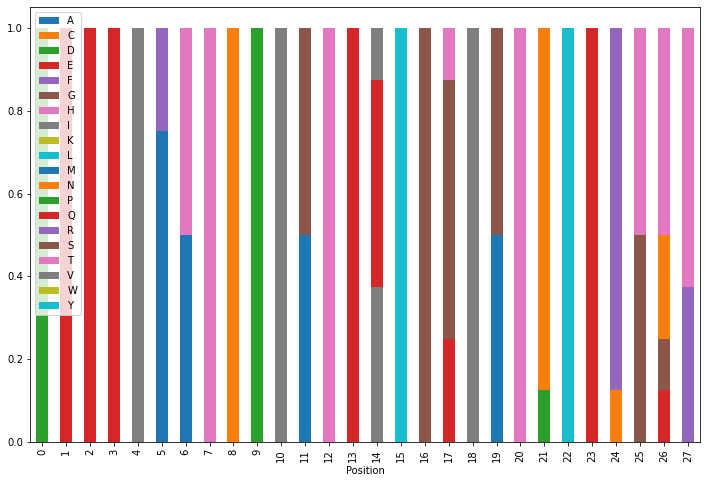

In [ ]:
plot_logo(df[(df.beats_wt==1) & (df.VAE_virus_S>7)].aa.values)

Here's the residue plot for high scoring generated sequences 

<AxesSubplot:xlabel='Position'>

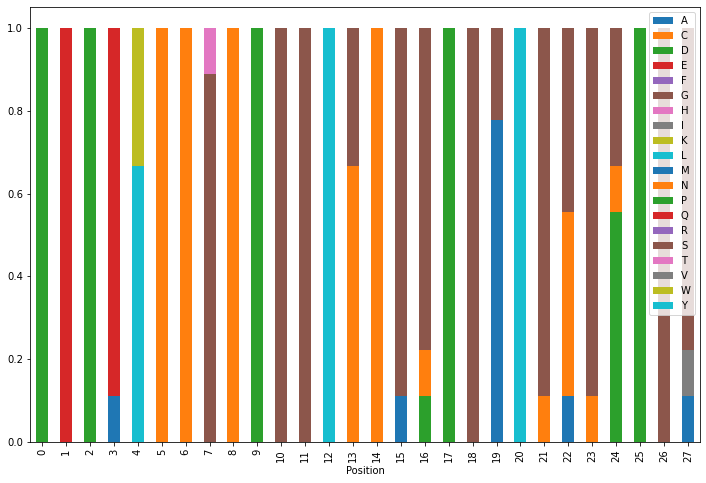

In [ ]:
plot_logo(env.log.df[(env.log.df.virus>8.9) & ~(env.log.df.sources=='data_buffer')].samples.values)

We can see similarities between dataset and generated sequences at positions 0, 1, 3, 8, 9, 16, and 19. We can see the generated compounds differ significantly at other residues. The lack of `T` residues in generates sequences relative to dataset sequences is interesting.

So are these residue changes real and meaningful? That depends on the quality of our score function. The only way to know is to test sequences in the lab